In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('final_data.csv')
data = data.dropna()
data = data.drop_duplicates()
data = data.reset_index(drop=True)

# Preprocess the data like for randomForest_simplified.ipynb
# Encode the sequence
# Define the 20 standard amino acids and include non-standard ones
amino_acids = 'ACDEFGHIKLMNPQRSTVWYU'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}


def one_hot_encode(seq, max_length):
    # Pad the sequence to the maximum length with 'X' (unknown amino acid)
    padded_seq = seq.ljust(max_length, 'X')
    int_encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in
                   padded_seq]  # Use a default index for unknown amino acids
    one_hot_encoded = np.zeros((max_length, len(amino_acids) + 1))  # +1 for the unknown amino acid
    for i, value in enumerate(int_encoded):
        one_hot_encoded[i, value] = 1
    return one_hot_encoded


# Determine the maximum sequence length
max_seq_length = max(data['Sequence'].apply(len))

# Encode the sequences
one_hot_encoded_sequences = np.array([one_hot_encode(seq, max_seq_length) for seq in data['Sequence']])

# Initialize the label encoder for charge states
label_encoder = LabelEncoder()
encoded_charge_states = label_encoder.fit_transform(data['Charge'].tolist())

# Reshape charge states to 3D, so that they match the dimensions of the one-hot-encoded sequences
# We repeat the charge value along the sequence length (max_seq_length) so that each sequence position has the charge value
encoded_charge_states_3d = np.repeat(encoded_charge_states[:, np.newaxis], max_seq_length, axis=1)

# Expand the charge states along the feature axis (the last axis) to match the shape of the one-hot-encoded sequences
encoded_charge_states_3d = np.expand_dims(encoded_charge_states_3d, axis=-1)

# Combine the one-hot encoded sequences and charge states into a single input array
# Concatenate along the feature axis (the last dimension)
X_combined = np.concatenate([one_hot_encoded_sequences, encoded_charge_states_3d], axis=2)

# The target variable (y) is the CCS value and will be normalized relative to the min and maximum CCS value
ccs_values = data['CCS'].values
normalized_ccs_values = (ccs_values - ccs_values.min()) / (ccs_values.max() - ccs_values.min())
y = normalized_ccs_values



In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))  # Correct input shape: (timesteps, features)
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], shuffle=False)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")


/Users/fabianschweisthal/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0030 - val_loss: 4.1021e-04
Epoch 2/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 6.8334e-04 - val_loss: 3.9435e-04
Epoch 3/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 6.2100e-04 - val_loss: 6.4927e-04
Epoch 4/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 6.0927e-04 - val_loss: 3.3891e-04
Epoch 5/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 5.9641e-04 - val_loss: 3.3731e-04
912/912 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Mean Squared Error: 0.00033730725123760794
R^2: 0.9910437030458373


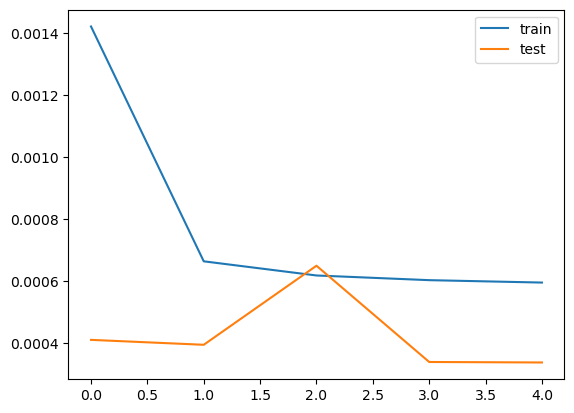

In [12]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()